In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import organs.system as system
from organs.index import Index
import organs.index as index

In [6]:
p = system.init()

n = len(Index)
y0 = np.zeros(n)

MMglucose = 180.16
MMfructose = 180.16
MMfattyacid = 256.43
MMprotein = 40000

glucosein = 250 #g
fructosein= 10 #g
fattyacidin= 10

def y0_init(y0: np.ndarray):
    y0[Index.plasma_glucose] = 5.5 #gmmol
    y0[Index.plasma_insulin] = 1.2 #g/L
    y0[Index.plasma_fattyacid] = 0.4 #mmol/L
    y0[Index.plasma_aminoacid] = 0.2 #mmol/L
    y0[Index.vsc_TAG] = 1 * 1000 /p.V.vsc  # g/L
    y0[Index.subq_TAG] = 10 * 1000 /p.V.subq  # g/L

    # volume of skeletal muscle is ~25.0L
    y0[Index.muscle_NAD] = 1.6*(60*.4)/25 #mmol/L 
    y0[Index.muscle_NADH] = 0.15*(60*.4)/25 #mmol/L
    y0[Index.liver_NAD] = 0.2/p.V.liver#mmol/L 
    y0[Index.liver_NADH] = 0.2/p.V.liver/3 #mmol/L
    y0[Index.muscle_FAD] = 1.6*(60*.4)/25/3 # NOTE: NEED UNITS
    y0[Index.muscle_FADH2] = 0.15*(60*.4)/25/3
    #no certain data for FAD and FADH2, but assume its around 1/3 of NAD
    y0[Index.liver_FAD] = 0.2/p.V.liver # NOTE: NEED UNITS
    y0[Index.liver_FADH2] = 0.2/p.V.liver/3 # NOTE: NEED UNITS

    y0[Index.gut_glucose] = glucosein/MMglucose*1000/p.V.gut # NOTE: NEED UNITS
    y0[Index.gut_fructose] = fructosein/MMglucose*1000/p.V.gut # NOTE: NEED UNITS # NOTE: NEED UNITS
    y0[Index.membrane_fattyacid] = fattyacidin/MMfattyacid*1000/p.V.gut # NOTE: NEED UNITS
    return

y0_init(y0)
t_span = (0, 12)
t_eval = np.linspace(*t_span, 300)


solution = solve_ivp(fun=lambda t, y: system.system(t, y, p),
                     t_span=t_span,
                     y0=y0,
                     t_eval=t_eval,
                     method='BDF')
y0 = solution.y[:, -1]


y0[Index.gut_glucose] += glucosein/MMglucose*1000/p.V.gut
t_span = (12,24)
t_eval = np.linspace(*t_span, 300)
solution2 = solve_ivp(fun=lambda t, y: system.system(t, y, p),
                     t_span=t_span,
                     y0=y0,
                     t_eval=t_eval,
                     method='BDF')

solution.t = np.append(solution.t, solution2.t, axis=0)
solution.y = np.append(solution.y, solution2.y, axis=1)
timespan = solution.t
print(len(solution.t))

\\wsl.localhost\Ubuntu\home\kewin\projects\pkpd\food_metabolism\organs\liver.py:135: RuntimeWarning: overflow encountered in scalar power
  dydt[Index.liver_mitochondrial_ACoA] = - p.Liver.k_ACoA_to_TCA * y[Index.liver_mitochondrial_ACoA] * y[Index.liver_NAD]**3 * y[Index.liver_FAD]
\\wsl.localhost\Ubuntu\home\kewin\projects\pkpd\food_metabolism\organs\liver.py:135: RuntimeWarning: invalid value encountered in scalar multiply
  dydt[Index.liver_mitochondrial_ACoA] = - p.Liver.k_ACoA_to_TCA * y[Index.liver_mitochondrial_ACoA] * y[Index.liver_NAD]**3 * y[Index.liver_FAD]
\\wsl.localhost\Ubuntu\home\kewin\projects\pkpd\food_metabolism\organs\liver.py:136: RuntimeWarning: overflow encountered in scalar power
  dydt[Index.liver_NAD] = - 3 * p.Liver.k_ACoA_to_TCA * y[Index.liver_mitochondrial_ACoA] * y[Index.liver_NAD]**3 * y[Index.liver_FAD]
\\wsl.localhost\Ubuntu\home\kewin\projects\pkpd\food_metabolism\organs\liver.py:136: RuntimeWarning: invalid value encountered in scalar multiply
  dyd

ValueError: array must not contain infs or NaNs

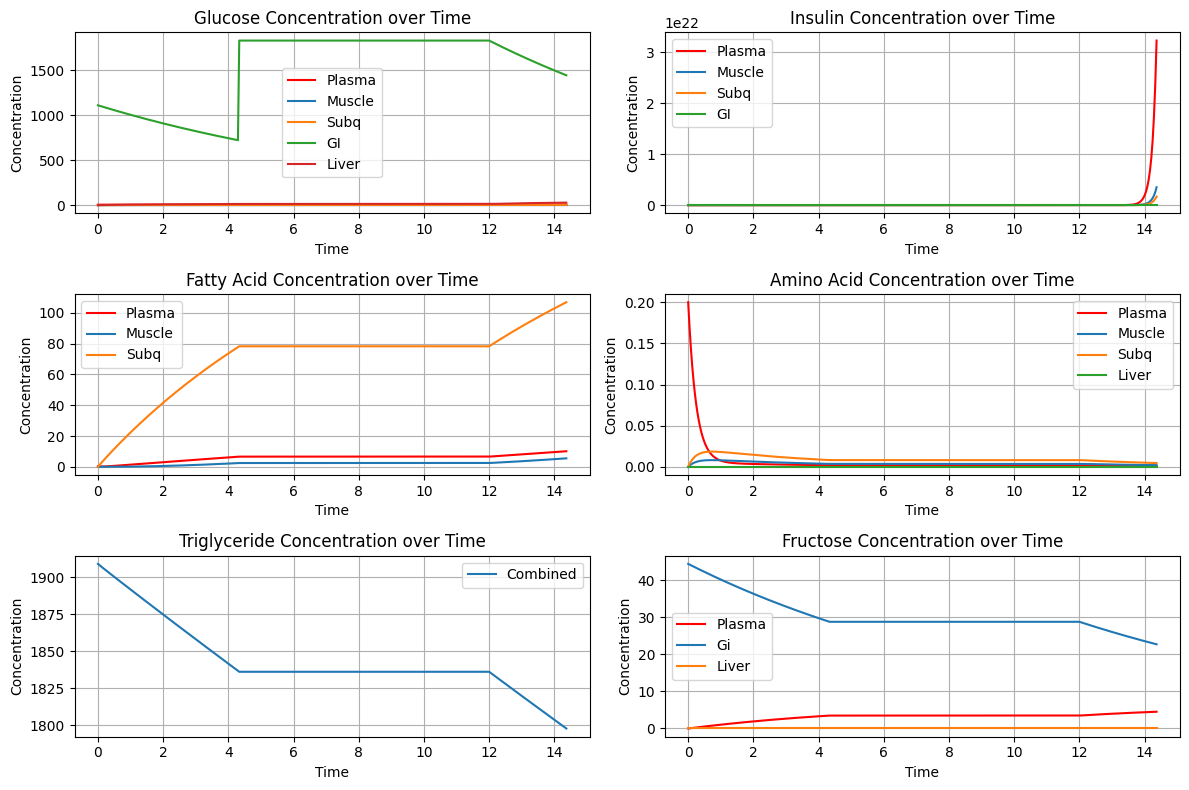

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(timespan, solution.y[Index.plasma_glucose], label='Plasma', color='red')
plt.plot(timespan, solution.y[Index.muscle_glucose], label='Muscle')
plt.plot(timespan, solution.y[Index.subq_glucose], label='Subq')
plt.plot(timespan, solution.y[Index.gut_glucose], label='GI')
plt.plot(timespan, solution.y[Index.liver_glucose], label='Liver')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Glucose Concentration over Time')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(timespan, solution.y[Index.plasma_insulin], label='Plasma', color='red')
plt.plot(timespan, solution.y[Index.muscle_insulin], label='Muscle')
plt.plot(timespan, solution.y[Index.subq_insulin], label='Subq')
plt.plot(timespan, np.zeros(len(timespan)), label='GI')
#plt.plot(timespan, solution.y[Index.liver_insulin], label='Liver')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Insulin Concentration over Time')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 3)
plt.plot(timespan, solution.y[Index.plasma_fattyacid], label='Plasma', color='red')
plt.plot(timespan, solution.y[Index.muscle_fattyacid], label='Muscle')
plt.plot(timespan, solution.y[Index.subq_fattyacid], label='Subq')

#plt.plot(timespan, solution.y[Index.liver_insulin], label='Liver')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Fatty Acid Concentration over Time')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(timespan, solution.y[Index.plasma_aminoacid], label='Plasma', color='red')
plt.plot(timespan, solution.y[Index.muscle_aminoacid], label='Muscle')
plt.plot(timespan, solution.y[Index.subq_aminoacid], label='Subq')
#plt.plot(timespan, solution.y[Index.gut_aminoacid], label='GI')
plt.plot(timespan, solution.y[Index.liver_aminoacid], label='Liver')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Amino Acid Concentration over Time')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 5)
plt.plot(timespan, solution.y[Index.subq_TAG]+solution.y[Index.vsc_TAG], label='Combined')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Triglyceride Concentration over Time')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 6)
plt.plot(timespan, solution.y[Index.plasma_fructose], label='Plasma', color='red')
plt.plot(timespan, solution.y[Index.gut_fructose], label='Gi')
plt.plot(timespan, solution.y[Index.liver_fructose], label='Liver')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Fructose Concentration over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\cubec\AppData\Local\Temp\ipykernel_19224\1965497089.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


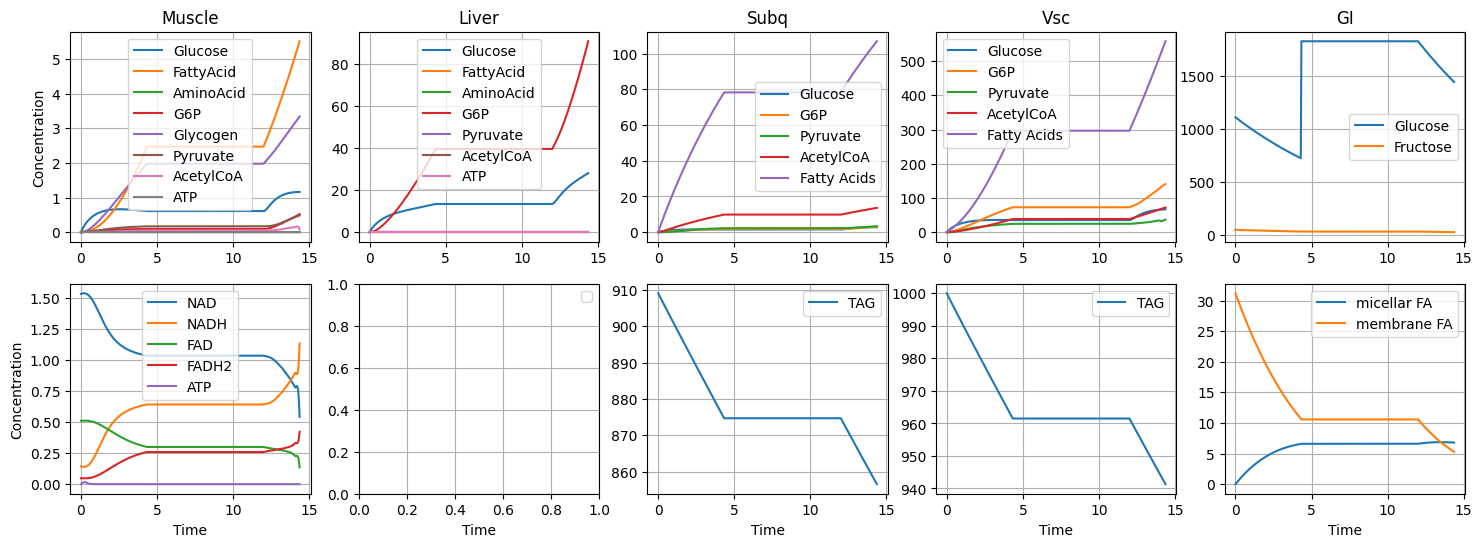

In [7]:
plt.figure(figsize=(18, 6))
plt.subplot(2, 5, 1)
plt.plot(timespan, solution.y[Index.muscle_glucose], label='Glucose')
plt.plot(timespan, solution.y[Index.muscle_fattyacid], label='FattyAcid')
plt.plot(timespan, solution.y[Index.muscle_aminoacid], label='AminoAcid')
plt.plot(timespan, solution.y[Index.muscle_G6P], label='G6P')
plt.plot(timespan, solution.y[Index.muscle_glycogen], label='Glycogen')
plt.plot(timespan, solution.y[Index.muscle_pyruvate], label='Pyruvate')
plt.plot(timespan, solution.y[Index.muscle_ACoA], label='AcetylCoA')
plt.plot(timespan, solution.y[Index.muscle_ATP], label='ATP')

plt.ylabel('Concentration')
plt.title('Muscle')
plt.legend()
plt.grid(True)

plt.subplot(2, 5, 2)
plt.plot(timespan, solution.y[Index.liver_glucose], label='Glucose')
plt.plot(timespan, solution.y[Index.liver_fattyacid], label='FattyAcid')
plt.plot(timespan, solution.y[Index.liver_aminoacid], label='AminoAcid')
plt.plot(timespan, solution.y[Index.liver_G6P], label='G6P')
plt.plot(timespan, solution.y[Index.liver_extracellular_pyruvate], label='Pyruvate')
plt.plot(timespan, solution.y[Index.liver_ACoA], label='AcetylCoA')
plt.plot(timespan, solution.y[Index.liver_ATP], label='ATP')

plt.title('Liver')
plt.legend()
plt.grid(True)

plt.subplot(2,5, 3)

plt.plot(timespan, solution.y[Index.subq_glucose], label='Glucose')
plt.plot(timespan, solution.y[Index.subq_G6P], label='G6P')
#plt.plot(timespan, solution.y[Index.subq_TAG], label='Triglycerides')
plt.plot(timespan, solution.y[Index.subq_pyruvate], label='Pyruvate')
plt.plot(timespan, solution.y[Index.subq_ACoA], label='AcetylCoA')
plt.plot(timespan, solution.y[Index.subq_fattyacid], label='Fatty Acids')


plt.title('Subq')
plt.legend()
plt.grid(True)

plt.subplot(2, 5, 4)
plt.plot(timespan, solution.y[Index.vsc_glucose], label='Glucose')
plt.plot(timespan, solution.y[Index.vsc_G6P], label='G6P')
plt.plot(timespan, solution.y[Index.vsc_pyruvate], label='Pyruvate')
plt.plot(timespan, solution.y[Index.vsc_ACoA], label='AcetylCoA')
plt.plot(timespan, solution.y[Index.vsc_fattyacid], label='Fatty Acids')


plt.title('Vsc')
plt.legend()
plt.grid(True)
plt.subplot(2, 5, 5)
plt.plot(timespan, solution.y[Index.gut_glucose], label='Glucose')
plt.plot(timespan, solution.y[Index.gut_fructose], label='Fructose')
plt.title('GI')



plt.legend()
plt.grid(True)
plt.subplot(2, 5, 6)

plt.plot(timespan, solution.y[Index.muscle_NAD], label='NAD')
plt.plot(timespan, solution.y[Index.muscle_NADH], label='NADH')
plt.plot(timespan, solution.y[Index.muscle_FAD], label='FAD')
plt.plot(timespan, solution.y[Index.muscle_FADH2], label='FADH2')
plt.plot(timespan, solution.y[Index.muscle_ATP], label='ATP')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)

plt.subplot(2, 5, 7)
#plt.plot(timespan, solution.y[Index.liver_fattyacids], label='fattyacids')
#plt.plot(timespan, solution.y[Index.liver_G6P], label='G6P')
#plt.plot(timespan, solution.y[Index.liver_pyruvate], label='Pyruvate')
#plt.plot(timespan, solution.y[Index.liver_ACoA], label='AcetylCoA')
plt.xlabel('Time')


plt.legend()
plt.grid(True)

plt.subplot(2, 5, 8)
plt.plot(timespan, solution.y[Index.subq_TAG], label='TAG')

plt.xlabel('Time')


plt.legend()
plt.grid(True)
plt.subplot(2, 5, 9)
plt.plot(timespan, solution.y[Index.vsc_TAG], label='TAG')

plt.xlabel('Time')


plt.legend()
plt.grid(True)

plt.subplot(2, 5, 10)
plt.plot(timespan, solution.y[Index.micellar_fattyacid], label='micellar FA')
plt.plot(timespan, solution.y[Index.membrane_fattyacid], label='membrane FA')



plt.xlabel('Time')


plt.legend()
plt.grid(True)

C:\Users\cubec\AppData\Local\Temp\ipykernel_24940\3941052867.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\cubec\AppData\Local\Temp\ipykernel_24940\3941052867.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


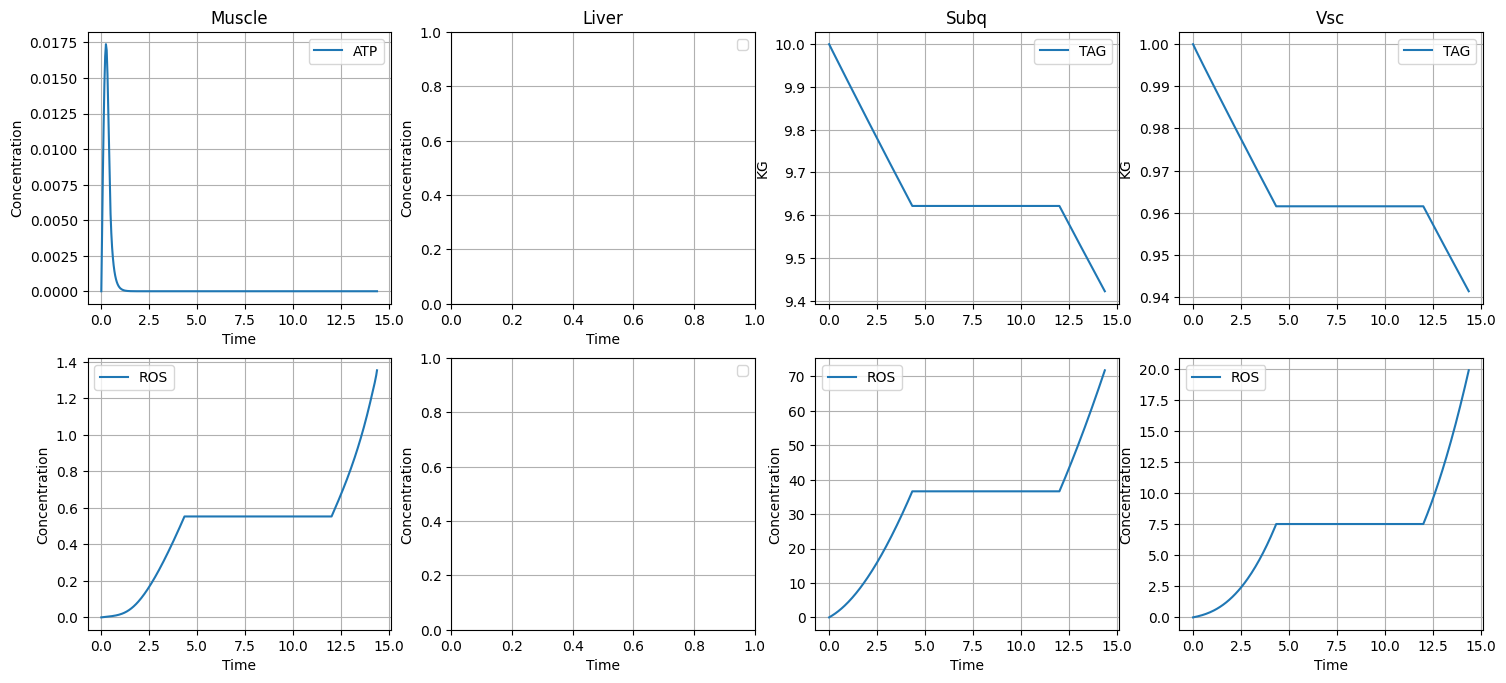

In [ ]:
plt.figure(figsize=(18, 12))
plt.subplot(3, 4, 1)
plt.plot(timespan, solution.y[Index.muscle_ATP], label='ATP')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Muscle')
plt.legend()
plt.grid(True)

plt.subplot(3, 4, 2)
#plt.plot(timespan, solution.y[Index.liver_ATP], label='ATP')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Liver')
plt.legend()
plt.grid(True)



plt.subplot(3, 4, 3)
plt.plot(timespan, solution.y[Index.subq_TAG]*p.V.subq/1000, label='TAG')
plt.ylabel('KG')
plt.title('Subq')
plt.legend()
plt.grid(True)

plt.subplot(3, 4, 4)
plt.plot(timespan, solution.y[Index.vsc_TAG]*p.V.vsc/1000, label='TAG')
plt.ylabel('KG')
plt.title('Vsc')
plt.legend()
plt.grid(True)

plt.subplot(3, 4, 5)

plt.plot(timespan, solution.y[Index.muscle_ROS]*p.V.muscle, label='ROS')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)

plt.subplot(3, 4, 6)
#plt.plot(timespan, solution.y[Index.liver_ROS]*p.V.liver, label='ROS')
plt.xlabel('Time')
plt.ylabel('Concentration')

plt.legend()
plt.grid(True)

plt.subplot(3, 4, 7)
plt.plot(timespan, solution.y[Index.subq_ROS]*p.V.subq, label='ROS')

plt.xlabel('Time')
plt.ylabel('Concentration')

plt.legend()
plt.grid(True)
plt.subplot(3, 4, 8)
plt.plot(timespan, solution.y[Index.vsc_ROS]*p.V.vsc, label='ROS')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.grid()
plt.legend()




